<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> DistilBERT </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
The Embedding Layer is the first layer in the architecture. It is divided into three parts: token embeddings, position embeddings, and type embeddings. Token Embeddings reflect the input tokens, location Embeddings encode each token's location in the sequence, and Type Embeddings distinguish between distinct segments or types of tokens.<br><br>

The DistilBERT architecture is built around the Encoder. It is made up of many Blocks (indicated as Block 1 through Block N). A Multi-Head Attention mechanism and a Feed Forward neural network layer are included in each block. The Multi-Head Attention layer focuses on distinct sections of the input sequence, recording token connections and linkages. The attended output is processed by the Feed Forward layer. These processes are repeated for each encoder block.<br><br>

To normalise the output and stabilise the training process, each encoder block is followed by a Layer Normalisation step.<br><br>

The Output Layer is the architecture's last layer. It has a Pooling component that aggregates data from encoded tokens. Mean and maximum pooling are applied to the output of the previous block, and the special classification token (CLS token) is also taken into account. The pooled representations are then sent into a Classifier layer, which performs tasks like text categorization and named entity identification.<br><br>

The graph depicts the data flow and links between the various components of the DistilBERT architecture.<br><br>
    
</div>

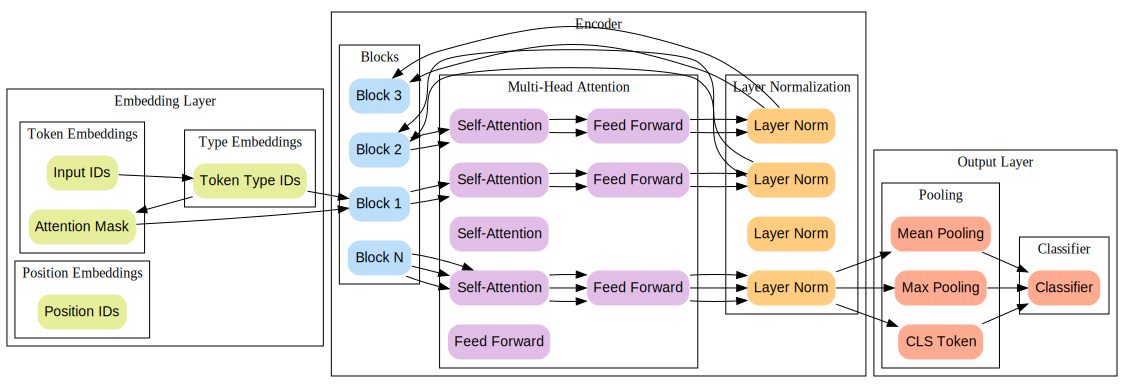

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/distilbert.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Importing modules
    </div>

In [2]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Loading the data    </div>

In [3]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining custom dataset class    </div>

In [4]:
# Define a custom dataset
class DisasterTweetsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, is_test=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = self.data['text'][index]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        if self.is_test:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
        else:
            label = torch.tensor(self.data['target'][index])
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': label
            }


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting up the tokenizer and model    </div>

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting device and defining training parameters    </div>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
max_length = 128
num_epochs = 50
learning_rate = 2e-5


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating train dataset and loader    </div>

In [7]:
train_dataset = DisasterTweetsDataset(train_data, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Sanity check of train loader    </div>

In [8]:
for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[  101,  1030,  2726,  ...,     0,     0,     0],
        [  101, 14252,  2739,  ...,     0,     0,     0],
        [  101, 21056,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  3963,  2086,  ...,     0,     0,     0],
        [  101,  7798,  1996,  ...,     0,     0,     0],
        [  101,  1005,  2144,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0])}


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Pushing model to device along with defining optimizer and loss function    </div>

In [9]:
model.to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Fine tuning the model for 5 epochs    </div>

In [10]:
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')


Epoch 1/50, Loss: 202.9485
Epoch 2/50, Loss: 153.9002
Epoch 3/50, Loss: 112.2518
Epoch 4/50, Loss: 76.6277
Epoch 5/50, Loss: 53.6900
Epoch 6/50, Loss: 40.1528
Epoch 7/50, Loss: 33.7921
Epoch 8/50, Loss: 27.4562
Epoch 9/50, Loss: 25.9538
Epoch 10/50, Loss: 21.0754
Epoch 11/50, Loss: 22.2934
Epoch 12/50, Loss: 19.6012
Epoch 13/50, Loss: 17.3760
Epoch 14/50, Loss: 18.7623
Epoch 15/50, Loss: 14.4010
Epoch 16/50, Loss: 16.3319
Epoch 17/50, Loss: 14.2513
Epoch 18/50, Loss: 13.0459
Epoch 19/50, Loss: 14.0214
Epoch 20/50, Loss: 12.8988
Epoch 21/50, Loss: 13.5883
Epoch 22/50, Loss: 9.2896
Epoch 23/50, Loss: 12.0857
Epoch 24/50, Loss: 7.7676
Epoch 25/50, Loss: 6.7695
Epoch 26/50, Loss: 6.0630
Epoch 27/50, Loss: 11.8912
Epoch 28/50, Loss: 8.8667
Epoch 29/50, Loss: 6.4734
Epoch 30/50, Loss: 10.4209
Epoch 31/50, Loss: 7.0319
Epoch 32/50, Loss: 5.6474
Epoch 33/50, Loss: 6.7037
Epoch 34/50, Loss: 5.0106
Epoch 35/50, Loss: 5.7746
Epoch 36/50, Loss: 3.7965
Epoch 37/50, Loss: 5.5181
Epoch 38/50, Loss: 7

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating test dataset    </div>

In [11]:
test_dataset = DisasterTweetsDataset(test_data, tokenizer, max_length, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Pushing model to eval mode    </div>

In [12]:
model.eval()
predictions = []


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generating predictions    </div>

In [13]:
from tqdm import tqdm
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(predicted_labels.tolist())



100%|██████████| 3263/3263 [00:20<00:00, 155.49it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generating submission file    </div>

In [14]:
submission_data = {'id': test_data['id'], 'target': predictions}
submission_df = pd.DataFrame(submission_data)


In [15]:
submission_df.to_csv('submission.csv', index=False)

In [16]:
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
